## Code to pull data ESPN Salary data and RAPM data to approximate player value. 

Author: Evan Tsiklidis

In [1]:
#Import useful libraries
import pandas as pd
import requests
import numpy as np
from bs4 import BeautifulSoup

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
#What years are we interested in? 
years = ['2010-11','2011-12','2012-13','2013-14','2014-15','2015-16']

In [3]:
#Store salary data for every player in the NBA. Historical salary data must be pulled from ESPN.COM
salary = pd.DataFrame({})
for year in years: 
    year = '20' + year[-2:]
    for page_num in range(1,20): 
        url = 'http://www.espn.com/nba/salaries/_/year/' + str(year) + '/page/' + str(page_num) + '/seasontype/4'
        data = requests.get(url)
        with open(year + ".html", "w+") as f:
            f.write(data.text)             
        with open(year + ".html") as f:
            page = f.read()
        soup = BeautifulSoup(page, 'html.parser')
        salary_table = soup.find_all(id='my-players-table')
        my_table = pd.read_html(str(salary_table))[0]
        my_table.columns = ['RK','Name','Team','Salary']
        my_table['Year'] = int(year)
        salary = pd.concat([salary,my_table],axis=0)
salary = salary[salary['Salary']!='SALARY'] #Remove random 'SALARY' header every few lines. 
salary[['Name','Position']] = salary.Name.str.split(", ",expand=True) #Restructure player names to be consistent with 
                                                                      #NBA.com RAPM 
salary[['First Name','Last Name']] = salary.Name.str.split(" ",1,expand=True) #Get First/Last Name.
salary['First Initial'] = salary['First Name'].str[:1] #First initial
salary['Name'] = salary['First Initial'] + '. ' + salary['Last Name']
salary = salary[['Name','Salary']]
salary[salary.columns[1:]] = salary[salary.columns[1:]].replace('[\$,]', '', regex=True).astype(float)
salary = salary.groupby(['Name']).sum().reset_index() #Get the sum of every player's salary during that time-period. 
salary.head()

,Name,Salary
0,A. Afflalo,40459577.0
1,A. Ajinca,10410091.0
2,A. Aminu,21040261.0
3,A. Anderson,7291954.0
4,A. Bargnani,53225397.0


In [4]:
#Pull Average +/- from NBA.COM. 
#Unfortunately, the data is aggregated into averages and only the most common lineups are present. 
df = pd.DataFrame({})
for year in years: 
    url = 'https://stats.nba.com/stats/leaguedashlineups'
    headers = {
        'Referer': 'https://www.nba.com/',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36'}
    payload = {
    'Conference': '',
    'DateFrom': '',
    'DateTo': '',
    'Division': '',
    'GameID': '',
    'GameSegment': '',
    'GroupQuantity': '5',
    'LastNGames': '0',
    'LeagueID': '00',
    'Location': '',
    'MeasureType': 'Base',
    'Month': '0',
    'OpponentTeamID': '0',
    'Outcome': '',
    'PORound': '0',
    'PaceAdjust': 'N',
    'PerMode': 'PerMinute',
    'Period': '0',
    'PlusMinus': 'N',
    'Rank': 'N',
    'Season': year,
    'SeasonSegment': '',
    'SeasonType': 'Regular Season',
    'ShotClockRange': '',
    'TeamID': '0',
    'VsConference': '',
    'VsDivision':  ''   }

    #Use the 'get' function to pull data from the URL.
    jsonData = requests.get(url, headers=headers, params=payload).json()
    cols = jsonData['resultSets'][0]['headers']
    t = pd.DataFrame(jsonData['resultSets'][0]['rowSet'],
                          columns=cols) 
    df = pd.concat([df,t],axis=0)
    
df = df[['GROUP_ID','GROUP_NAME','TEAM_ABBREVIATION','MIN','PLUS_MINUS']]
df.head()

,GROUP_ID,GROUP_NAME,TEAM_ABBREVIATION,MIN,PLUS_MINUS
0,-965-977-1885-1897-2200-,D. Fisher - K. Bryant - L. Odom - M. World Pea...,LAL,952.758333,0.27
1,-2561-2731-2772-101108-201158-,D. West - E. Okafor - T. Ariza - C. Paul - M. ...,NOH,882.615000,0.07
2,-2203-2449-2755-101236-200768-,S. Battier - L. Scola - K. Martin - C. Hayes -...,HOU,796.418333,0.20
3,-1882-2738-201150-201950-201975-,E. Brand - A. Iguodala - S. Hawes - J. Holiday...,PHI,776.855000,0.13
4,-965-977-1897-2200-101115-,D. Fisher - K. Bryant - M. World Peace - P. Ga...,LAL,762.333333,0.20


In [5]:
#Dissect groups into individual players and unique player ID numbers
temp = df.GROUP_NAME.str.split(' - ',expand=True)
temp.columns = ['Player1','Player2','Player3','Player4','Player5']
df = pd.concat([df,temp],axis=1)
temp = df.GROUP_ID.str.split('-',expand=True).reset_index(drop=True)
temp.columns = ['0','ID1','ID2','ID3','ID4','ID5','7']
temp = temp[['ID1','ID2','ID3','ID4','ID5']].reset_index(drop=True)
df = pd.concat([df.reset_index(drop=True),temp],axis=1)
df = df[['Player1','Player2','Player3','Player4','Player5','ID1','ID2','ID3','ID4','ID5','PLUS_MINUS','MIN','TEAM_ABBREVIATION']]
df.head()

,Player1,Player2,Player3,Player4,Player5,ID1,ID2,ID3,ID4,ID5,PLUS_MINUS,MIN,TEAM_ABBREVIATION
0,D. Fisher,K. Bryant,L. Odom,M. World Peace,P. Gasol,965,977,1885,1897,2200,0.27,952.758333,LAL
1,D. West,E. Okafor,T. Ariza,C. Paul,M. Belinelli,2561,2731,2772,101108,201158,0.07,882.615000,NOH
2,S. Battier,L. Scola,K. Martin,C. Hayes,K. Lowry,2203,2449,2755,101236,200768,0.20,796.418333,HOU
3,E. Brand,A. Iguodala,S. Hawes,J. Holiday,J. Meeks,1882,2738,201150,201950,201975,0.13,776.855000,PHI
4,D. Fisher,K. Bryant,M. World Peace,P. Gasol,A. Bynum,965,977,1897,2200,101115,0.20,762.333333,LAL


In [6]:
#Connect player to player ID.
df['PlayerID1'] = df['Player1'] + ' - '+df['ID1'].astype(str) 
df['PlayerID2'] = df['Player2'] + ' - '+df['ID2'].astype(str)
df['PlayerID3'] = df['Player3'] + ' - '+df['ID3'].astype(str)
df['PlayerID4'] = df['Player4'] + ' - '+df['ID4'].astype(str)
df['PlayerID5'] = df['Player5'] + ' - '+df['ID5'].astype(str)
df.head()

,Player1,Player2,Player3,Player4,Player5,ID1,ID2,ID3,ID4,ID5,PLUS_MINUS,MIN,TEAM_ABBREVIATION,PlayerID1,PlayerID2,PlayerID3,PlayerID4,PlayerID5
0,D. Fisher,K. Bryant,L. Odom,M. World Peace,P. Gasol,965,977,1885,1897,2200,0.27,952.758333,LAL,D. Fisher - 965,K. Bryant - 977,L. Odom - 1885,M. World Peace - 1897,P. Gasol - 2200
1,D. West,E. Okafor,T. Ariza,C. Paul,M. Belinelli,2561,2731,2772,101108,201158,0.07,882.615000,NOH,D. West - 2561,E. Okafor - 2731,T. Ariza - 2772,C. Paul - 101108,M. Belinelli - 201158
2,S. Battier,L. Scola,K. Martin,C. Hayes,K. Lowry,2203,2449,2755,101236,200768,0.20,796.418333,HOU,S. Battier - 2203,L. Scola - 2449,K. Martin - 2755,C. Hayes - 101236,K. Lowry - 200768
3,E. Brand,A. Iguodala,S. Hawes,J. Holiday,J. Meeks,1882,2738,201150,201950,201975,0.13,776.855000,PHI,E. Brand - 1882,A. Iguodala - 2738,S. Hawes - 201150,J. Holiday - 201950,J. Meeks - 201975
4,D. Fisher,K. Bryant,M. World Peace,P. Gasol,A. Bynum,965,977,1897,2200,101115,0.20,762.333333,LAL,D. Fisher - 965,K. Bryant - 977,M. World Peace - 1897,P. Gasol - 2200,A. Bynum - 101115


In [7]:
#All we care about players on the court together and what there average +/- was
df = df[['PlayerID1','PlayerID2','PlayerID3','PlayerID4','PlayerID5','PLUS_MINUS','MIN']]
df.head()

,PlayerID1,PlayerID2,PlayerID3,PlayerID4,PlayerID5,PLUS_MINUS,MIN
0,D. Fisher - 965,K. Bryant - 977,L. Odom - 1885,M. World Peace - 1897,P. Gasol - 2200,0.27,952.758333
1,D. West - 2561,E. Okafor - 2731,T. Ariza - 2772,C. Paul - 101108,M. Belinelli - 201158,0.07,882.615000
2,S. Battier - 2203,L. Scola - 2449,K. Martin - 2755,C. Hayes - 101236,K. Lowry - 200768,0.20,796.418333
3,E. Brand - 1882,A. Iguodala - 2738,S. Hawes - 201150,J. Holiday - 201950,J. Meeks - 201975,0.13,776.855000
4,D. Fisher - 965,K. Bryant - 977,M. World Peace - 1897,P. Gasol - 2200,A. Bynum - 101115,0.20,762.333333


In [9]:
#Convert the players into dummy variable representations... necessary for the ML part. 
playerheaderlist = ['PlayerID1','PlayerID2','PlayerID3','PlayerID4','PlayerID5']
t = pd.DataFrame({})
for player in playerheaderlist: 
    temp_dummy = pd.get_dummies(df[player])
    t = pd.concat([t,temp_dummy],axis=1)

In [10]:
playerslist = df.PlayerID1.unique().tolist() + df.PlayerID2.unique().tolist()+df.PlayerID3.unique().tolist()+\
df.PlayerID4.unique().tolist() + df.PlayerID5.unique().tolist()
playerslist = list(set(playerslist))

In [12]:
#Group players into one column.. 
df_players = pd.DataFrame({})
for player in playerslist: 
    t2 = np.array(t[[player]]).sum(axis=1)
    t2 = pd.DataFrame(t2,columns = [player])
    df_players = pd.concat([df_players,t2],axis=1)
df = pd.concat([df_players.reset_index(drop=True),df[['PLUS_MINUS','MIN']].reset_index(drop=True)],axis=1) 
df[['MIN']] = np.round(df[['MIN']])
df.head()

,X. Henry - 202333,E. Najera - 2059,J. Terry - 1891,M. Ely - 2408,S. Blake - 2581,S. Curry - 203552,W. Tavares - 204002,B. Roberts - 203148,T. Hardaway Jr. - 203501,L. Scola - 2449,...,A. Varejao - 2760,C. Butler - 2406,S. Gaines - 202178,M. Thomas - 202952,C. Bosh - 2547,J. Howard - 2572,M. Ginobili - 1938,K. Martin - 2755,T. Battie - 1499,D. Milicic - 2545
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
features = df.columns.tolist()
features.remove('PLUS_MINUS')
features.remove('MIN')
X = df[features]
y = df[['PLUS_MINUS']]*36 #Convert this into 'per 36 minutes'

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [20]:
#Train interpretable model.. consistent with literature. 
reg = Ridge(alpha=50)
reg.fit(X_train, y_train)

Ridge(alpha=50)

In [21]:
reg.predict(X_test)
mean_absolute_error(y_test, reg.predict(X_test))

13.907516304444373

In [22]:
my_dict = {'Players':features,'coeff':reg.coef_.tolist()[0]}
results = pd.DataFrame(my_dict)
results

,Players,coeff
0,X. Henry - 202333,-0.975378
1,E. Najera - 2059,-0.219172
2,J. Terry - 1891,1.946825
3,M. Ely - 2408,0.969023
4,S. Blake - 2581,0.898902
...,...,...
786,J. Howard - 2572,-2.184697
787,M. Ginobili - 1938,6.087573
788,K. Martin - 2755,-2.147483
789,T. Battie - 1499,-0.463646


<AxesSubplot:>

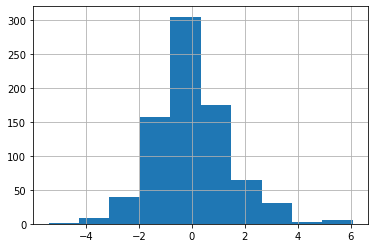

In [23]:
results.coeff.hist()

In [24]:
t = results.Players.str.split(" - ",expand=True)
t.columns = ['Name','ID']
results = pd.concat([t[['Name']],results],axis=1)[['Name','coeff']]
results.head()

,Name,coeff
0,X. Henry,-0.975378
1,E. Najera,-0.219172
2,J. Terry,1.946825
3,M. Ely,0.969023
4,S. Blake,0.898902


In [25]:
salary = salary.groupby(['Name']).sum().reset_index()
salary.head()

,Name,Salary
0,A. Afflalo,40459577.0
1,A. Ajinca,10410091.0
2,A. Aminu,21040261.0
3,A. Anderson,7291954.0
4,A. Bargnani,53225397.0


In [26]:
final = results.merge(salary,left_on='Name',right_on='Name',how='inner')
final.head()

,Name,coeff,Salary
0,X. Henry,-0.975378,8481333.0
1,E. Najera,-0.219172,8500000.0
2,J. Terry,1.946825,38453902.0
3,M. Ely,0.969023,3909764.0
4,S. Blake,0.898902,20247465.0


In [27]:
final.to_csv('RAPM_SAL_INFO.csv')

In [28]:
# team_records = pd.DataFrame({})
# for year in years: 
#     year = '20' + year[-2:]
#     url = "https://www.basketball-reference.com/leagues/NBA_" + year + "_standings.html"
#     data = requests.get(url)
    
#     with open(year + ".html", "w+") as f:
#         f.write(data.text)  
# for year in years:         
#     with open(year + ".html") as f:
#         page = f.read()
#     soup = BeautifulSoup(page, 'html.parser')
#     rec_table = soup.find_all(id="div_confs_standings_W")
#     west = pd.read_html(str(rec_table))[0]
#     rec_table = soup.find_all(id="div_confs_standings_E")
#     east = pd.read_html(str(rec_table))[0]    
#     east['Season'] = year
#     west['Season'] = year
#     east.rename(columns = {'Eastern Conference':'Team Name'},inplace=True)
#     west.rename(columns = {'Western Conference':'Team Name'},inplace=True)
#     team_records = pd.concat([team_records,east,west],axis=0)
# team_records.head()